In [1]:
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt

In [7]:
def display_img(img, axis=False, grayscale=False):
    if grayscale:
        if len(img.shape) == 3:  # Check if the image is RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert BGR to grayscale
        cmap = 'gray'
    else:
        if len(img.shape) == 2:  # Check if the image is grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cmap = None

    plt.imshow(img, cmap=cmap)
    if not axis:
        plt.axis('off')
    plt.show()

# preprocessing

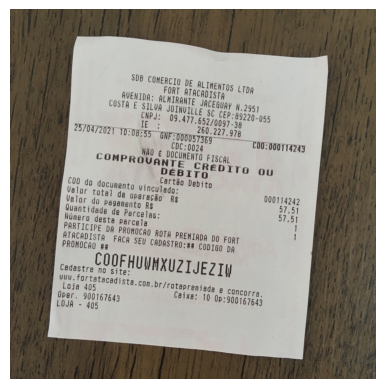

1061 1049


In [8]:
img = cv2.imread('Imagens/Imagens Projeto 2/doc_rotacionado01.jpg')
original = img.copy()
display_img(img)
(H, W) = img.shape[:2]
print(H, W)

# grayscale

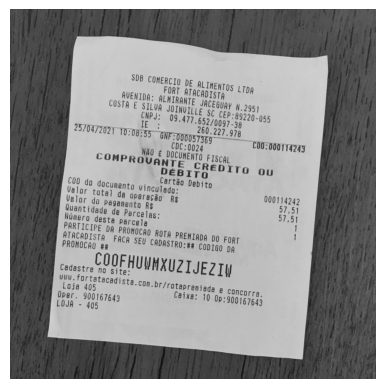

In [9]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display_img(gray)

# Gaussian Blur

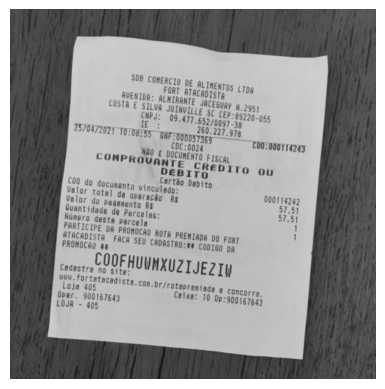

In [10]:
blur = cv2.GaussianBlur(gray, (5,5), 0)
display_img(blur)

# Canny Edge

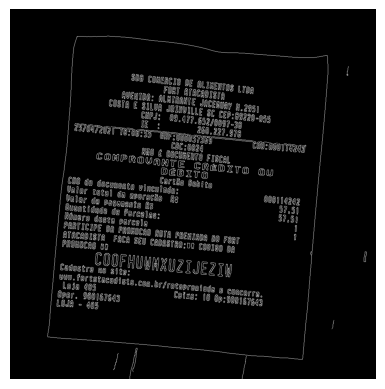

In [11]:
edge = cv2.Canny(blur, 60, 160)
display_img(edge)

# find contours

In [14]:
def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
    return conts

In [17]:

conts = find_contours(edge.copy())

In [18]:
conts

[array([[[278,  77]],
 
        [[277,  78]],
 
        [[250,  78]],
 
        ...,
 
        [[300,  78]],
 
        [[285,  78]],
 
        [[284,  77]]], dtype=int32),
 array([[[277,  78]],
 
        [[278,  77]],
 
        [[284,  77]],
 
        ...,
 
        [[246,  79]],
 
        [[249,  79]],
 
        [[250,  78]]], dtype=int32),
 array([[[298, 702]],
 
        [[296, 704]],
 
        [[295, 704]],
 
        [[294, 705]],
 
        [[294, 707]],
 
        [[293, 708]],
 
        [[293, 719]],
 
        [[292, 720]],
 
        [[292, 729]],
 
        [[291, 730]],
 
        [[291, 731]],
 
        [[292, 732]],
 
        [[292, 734]],
 
        [[295, 737]],
 
        [[296, 737]],
 
        [[297, 738]],
 
        [[301, 738]],
 
        [[302, 737]],
 
        [[304, 737]],
 
        [[307, 734]],
 
        [[307, 731]],
 
        [[308, 730]],
 
        [[308, 722]],
 
        [[309, 721]],
 
        [[309, 710]],
 
        [[310, 709]],
 
        [[309, 708]],
 
        

# contour localizer

In [21]:
for c in conts:
    perimeter =cv2.arcLength(c,True)
    aprox = cv2.approxPolyDP(c,0.02*perimeter, True)
    if len(aprox)==4:
        maior = aprox
        break

In [22]:
maior

array([[[ 192,   78]],

       [[ 108,  940]],

       [[ 838, 1004]],

       [[ 909,  133]]], dtype=int32)

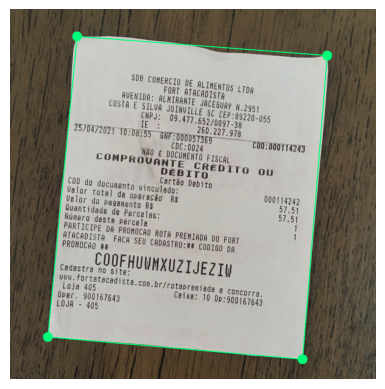

In [23]:
cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
display_img(img)

## Sorting the points
We already have the 4 x-y coordinates that correspond to the corners of the rectangle/polygon located in the image, but these points are likely to be in a random order. In order to perform the perspective transformation, we need to sort the points in a specific order, so that we can apply the transformation correctly.

It is crucial that the order of the rectangle points remains consistent throughout the program. If any of these points change order, the transformation will not be applied as desired.

We have chosen the following order:

1. **te** = top left (upper left)
2. **td** = top right (upper right)
3. **bd** = bottom right (lower right)
4. **be** = bottom left (lower left)


We prefer to use this order as it is a more commonly used convention. However, if you want, you can change the order. For example, you can place be before bd and after td. But if you choose to do so, you need to maintain this order in the rest of the program as well (specifically in the part related to pts2 that we will see below, by swapping [W, H] with [0, H]).

In [26]:
def sort_points(points):
  points = points.reshape((4,2))
  points_new = np.zeros((4, 1, 2), dtype=np.int32)

  add = points.sum(1)
  points_new[0] = points[np.argmin(add)]
  points_new[2] = points[np.argmax(add)]

  dif = np.diff(points, axis = 1)
  points_new[1] = points[np.argmin(dif)]
  points_new[3] = points[np.argmax(dif)]

  return points_new

In [27]:
larger_points = sort_points(maior)
print(larger_points)

[[[ 192   78]]

 [[ 909  133]]

 [[ 838 1004]]

 [[ 108  940]]]


## Obtaining the transformation matrix

In [28]:
pts1 = np.float32(larger_points)

In [29]:
pts1

array([[[ 192.,   78.]],

       [[ 909.,  133.]],

       [[ 838., 1004.]],

       [[ 108.,  940.]]], dtype=float32)

In [30]:
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

In [31]:
matrix = cv2.getPerspectiveTransform(pts1, pts2)
matrix

array([[ 1.47103022e+00,  1.43348652e-01, -2.93618997e+02],
       [-9.58731834e-02,  1.24983768e+00, -7.90796880e+01],
       [ 1.08773828e-05,  2.32288006e-05,  1.00000000e+00]])

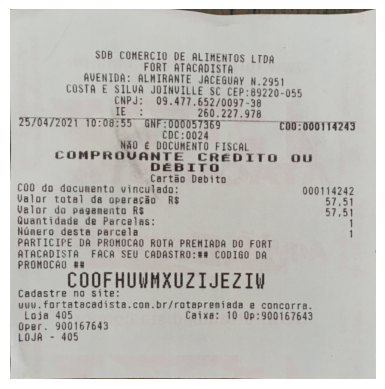

In [32]:
transform = cv2.warpPerspective(original, matrix, (W, H))
display_img(transform)

In [35]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = """C:\Program Files\Tesseract-OCR\\tesseract.exe"""

In [36]:
config_tesseract = "--tessdata-dir tessdata"
texto = pytesseract.image_to_string(transform, lang="por", config=config_tesseract)
print(texto)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
— AVENIDA: ALMIRANTE JACEGUAY N.2951
COSTA E SILVA JOINVILLE SC CEP:89220-055
CNPJ: 09.477.652/0097-38
7 SRAm 260.227.978
2570972027 T0:08:55" Gnrzggvgãzgsà““““'** ***** CO0T0001142A3
NÃO É DOCUMENTO FISCAL
COMPROUANTE CREDITO OU

DÉBIT

Cartão Debito
COO do documento vinculado: 000114242
Valor total da operação R$ RAA
Valor do pagamento R$ BTAA
Quantidade de Parcelas:
Núnmero desta parcela 1

PARTICIPE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:%% CODIGO DA
PROMOCAO &%

COOFHUWMXUZIJEZIV

Cadastre no site:
uuu.fortatacadista.con.br/rotapreniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405




# brightness

In [37]:
brilho = 50
contraste = 80
ajustes = np.int16(transform)
ajustes.shape

(1061, 1049, 3)

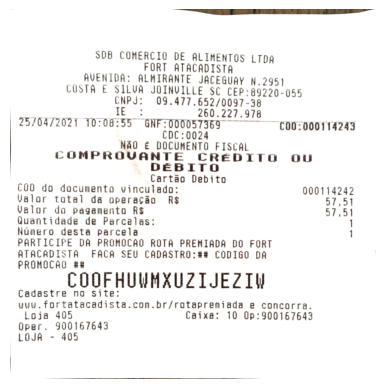

In [38]:
ajustes = ajustes * (contraste / 127 + 1) - contraste + brilho
ajustes = np.clip(ajustes, 0, 255)
ajustes = np.uint8(ajustes)
display_img(ajustes)

## Adaptive threshold

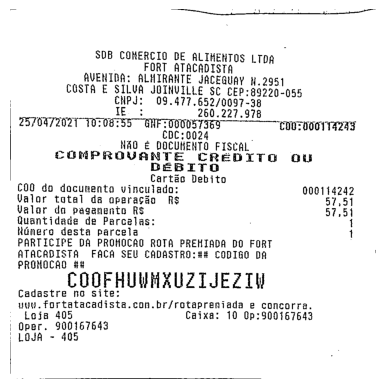

In [39]:
img_process = cv2.cvtColor(transform, cv2.COLOR_BGR2GRAY)
img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
display_img(img_process)

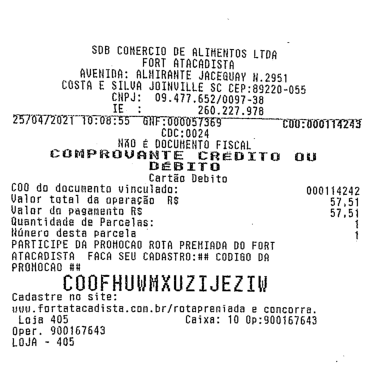

In [40]:
margem = 18
img_final = img_process[margem:H - margem, margem:W - margem]
display_img(img_final)

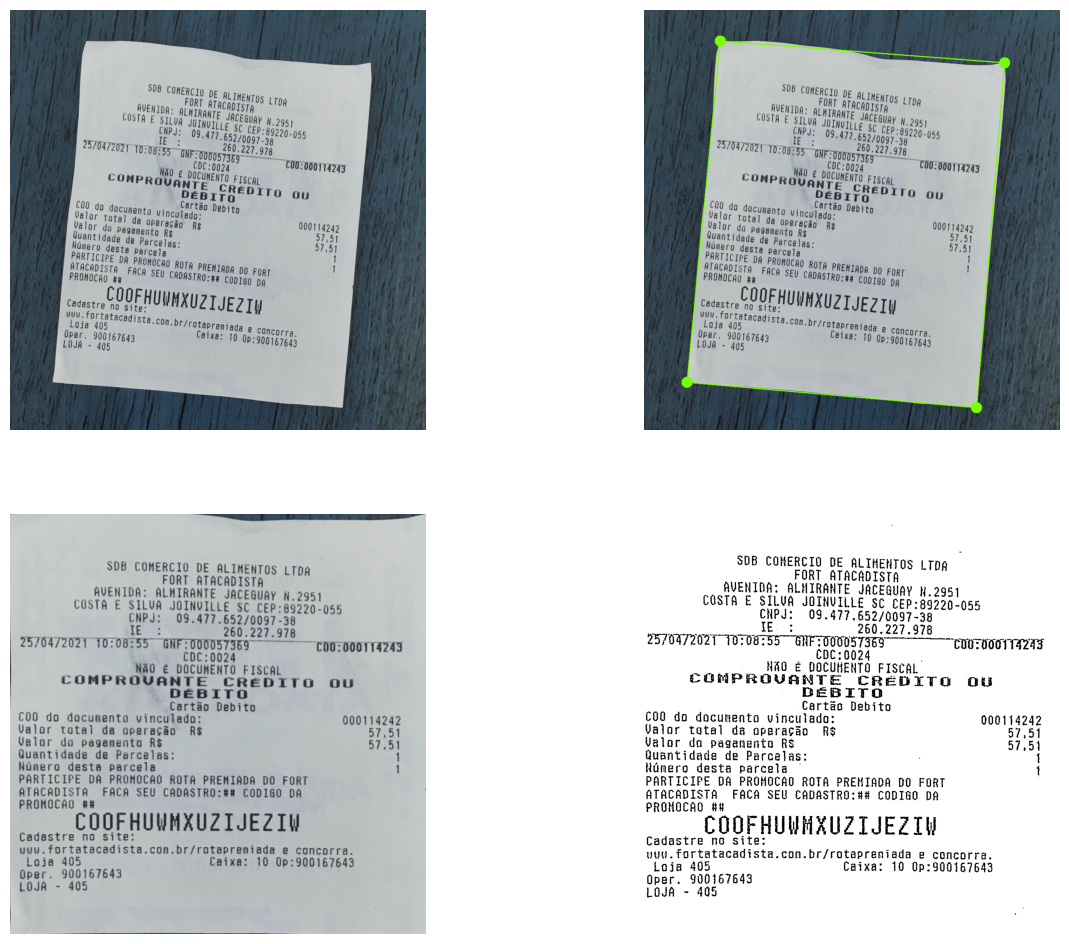

In [42]:
fig, im = plt.subplots(2, 2, figsize=(15,12))
for x in range(2):
  for y in range(2):
    im[x][y].axis('off')

im[0][0].imshow(original)
im[0][1].imshow(img)
im[1][0].imshow(transform, cmap='gray')
im[1][1].imshow(img_final, cmap='gray')
plt.show()

# results

In [43]:
def transform_imagem(nome_imagem):
  img = cv2.imread(nome_imagem)
  original = img.copy()
  display_img(img)
  (H, W) = img.shape[:2]

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (7, 7), 0)
  edged = cv2.Canny(blur, 60, 160)
  display_img(edged)
  conts = find_contours(edged.copy())
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(aprox) == 4:
      maior = aprox
      break

  cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
  cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
  display_img(img)

  pontosMaior = sort_points(maior)
  pts1 = np.float32(pontosMaior)
  pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

  matriz = cv2.getPerspectiveTransform(pts1, pts2)
  transform = cv2.warpPerspective(original, matriz, (W, H))
  display_img(transform)
  return transform

In [44]:
def processamento_img(img):
  img_process = cv2.resize(img, None, fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
  img_process = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
  return img_process

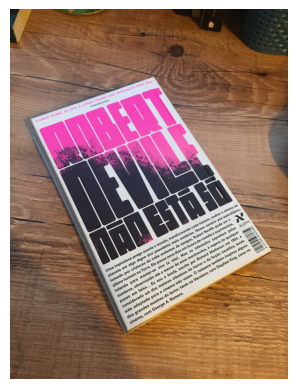

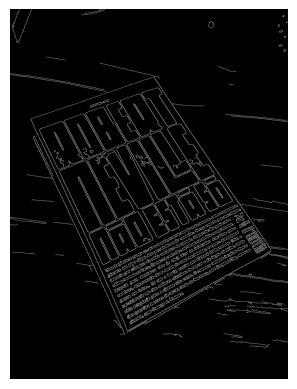

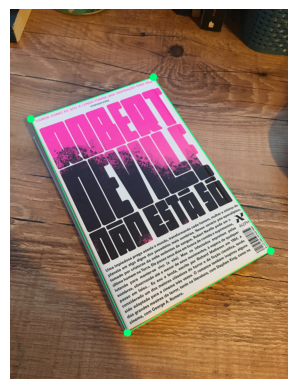

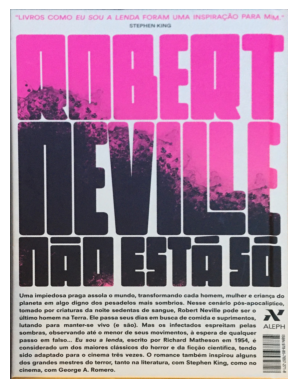

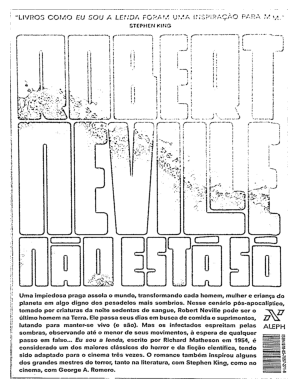

In [46]:
img = transform_imagem('Imagens/Imagens Projeto 2/livro_esal.jpg')
img_final = processamento_img(img)
display_img(img_final)

In [47]:
texto = pytesseract.image_to_string(img_final, lang="por", config=config_tesseract)
print(texto)

PAÇÃO PARA Mago

— “LIVROS COMO EU SOU A LENDA FGBA UMA
' STEPHEN KING

Uma impiedosa praga assola o mundo, transformando cada homem, mulher e criança do
planeta em algo digno dos pesadelos mais sombrios. Nesse cenário pós-apocalíptico,
tomado por criaturas da noite sedentas de sangue, Robert Neville pode ser o 7
último homem na Terra. Ele passa seus dias em busca de comida e suprimentos, A
lutando para manter-se vivo (e são). Mas os infectados espreitam pelas ALEPH
sombras, observando até o menor de seus movimentos, à espera de qualquer
passo em falso... Eu sou a lenda, escrito por Richard Matheson em 1954, é
considerado um dos maiores clássicos do horror e da ficção científica, tendo
sido adaptado para o cinema três vezes. O romance também inspirou alguns
dos grandes mestres do terror, tanto na literatura, com Stephen King, como no
cinema, com George A. Romero.

- 69LS8 9A NES:


